In [1]:
from pprint import pprint
from convertmol import parse_sdf_file, bond_type_dict, single_bond_stereo_dict, double_bond_stereo_dict
from torch_geometric.data import Data
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
import sascorer
torch.set_default_device('cpu:0')#'cuda'

In [2]:
from neo4j import GraphDatabase, RoutingControl


URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

In [3]:
import convertmol
import importlib
importlib.reload(convertmol)

<module 'convertmol' from 'C:\\Users\\umarzein\\Desktop\\biocheminformatics\\convertmol.py'>

In [6]:
import uuid

In [8]:
import re
invalid_key=re.compile(r'[^\w.-]')
def is_valid_fieldname(fieldname):
    return re.search(invalid_key, fieldname) is None

In [9]:
primitives = (bool, str, int, float, type(None))

def is_primitive(obj):
    return isinstance(obj, primitives)

In [10]:
def upload_mol(tx, mol:rdkit.Chem.rdchem.Mol, source, additional_properties=None):
    assert isinstance(source, str), "source must be str"
    # SOURCE
    tx.run(f"MERGE (:Source {{name: '{source}'}});")

    # MOLECULE
    n_confs = mol.GetNumConformers()
    props = {k:v for k,v in mol.GetPropsAsDict().items() if is_valid_fieldname(k) and is_primitive(v)}
    _Name=mol.GetProp("_Name")
    props['_Name']=_Name
    props['NumAtoms'] = mol.GetNumAtoms()
    props['NumHeavyAtoms'] = mol.GetNumHeavyAtoms()
    props['NumBonds'] = mol.GetNumBonds()
    props['NumConformers'] = n_confs
    
    if n_confs==1:
        conf=mol.GetConformer()
        props = {**props, **{k:v for k,v in conf.GetPropsAsDict().items() if is_valid_fieldname(k) and is_primitive(v)}}

    if isinstance(additional_properties, dict):
        props = {**props, **{k:v for k,v in additional_properties.items() if is_valid_fieldname(k) and is_primitive(v)}}
    
    mol_props = ", ".join([f"{key}: ${key}" for key in props.keys()])
    query = f"MATCH (s:Source {{name: '{source}'}}) MERGE (m:Molecule {{{mol_props}}})-[:PART_OF]->(s);"
    tx.run(query, props)
    
    # ATOMS
    for atom in (mol).GetAtoms():
        props = {k:v for k,v in atom.GetPropsAsDict().items() if is_primitive(v)}
        Idx=atom.GetIdx()
        props['Idx']=Idx
        props['Symbol']=atom.GetSymbol()
        props['ChiralTag']=str(atom.GetChiralTag())
        props['NumImplicitHs']=atom.GetNumImplicitHs()
        if n_confs>1: raise Exception("what does >1 conformer even mean??!")
        elif n_confs==1:
            pos=conf.GetAtomPosition(atom.GetIdx())
            props['x']=pos.x
            props['y']=pos.y
            props['z']=pos.z
        atom_props = ", ".join([f"{key}: ${key}" for key in props.keys()])
        query = f"MATCH (m: Molecule {{_Name: '{_Name}'}}) MERGE (a:Atom {{{atom_props}}})-[:PART_OF]->(m);"
        tx.run(query, props)

    # BONDS
    for bond in mol.GetBonds():
        props = {k:v for k,v in bond.GetPropsAsDict().items() if is_primitive(v)}
        props['Idx']=bond.GetIdx()
        props['IsAromatic']=bond.GetIsAromatic()
        props['IsConjugated']=bond.GetIsConjugated()
        props['BondType']=str(bond.GetBondType())
        props['Stereo']=str(bond.GetStereo())
        orig=bond.GetBeginAtomIdx()
        dest=bond.GetEndAtomIdx()
        props['BeginAtomIdx']=orig
        props['EndAtomIdx']=dest
        bond_props = ", ".join([f"{key}: ${key}" for key in props.keys()])
        query = f"MATCH (orig:Atom {{Idx: {orig}}})-[:PART_OF]->(m: Molecule {{_Name: '{_Name}'}}), \
            (dest:Atom {{Idx: {dest}}})-[:PART_OF]->(m: Molecule {{_Name: '{_Name}'}}) \
            MERGE \
                (orig)-[:BOND {{{bond_props}}}]->(dest);"
        tx.run(query, props)

In [12]:
from typing import List, Iterable
def upload_mols(tx, mols:Iterable[rdkit.Chem.rdchem.Mol], source, additional_properties:Iterable[dict]):
    for mol,ap in (zip(mols, additional_properties)):
        ret=upload_mol(tx, mol, source, ap)

In [25]:
def create_indexes(tx):
    # Creating an index on Atom properties
    #tx.run("CREATE INDEX atom_index IF NOT EXISTS FOR (a:Atom) ON (a.Idx)")
    # we dont need this, according to chatgpt
    # Creating an index on Molecule properties if molecules have specific identifiers
    #tx.run("CREATE INDEX molecule_index IF NOT EXISTS FOR (m:Molecule) ON (m._Name)")
    # we dont need this^, according to chatgpt, 
    # if our queries are like these:
    # MATCH (a:Atom)-[:PART_OF]->(m:Molecule)-[:PART_OF]->(s:Source {_Name: ...})
    # RETURN a, m, s

    
    # Creating an index on Source properties if there are specific identifiers like 'name' or 'source_id'
    tx.run("CREATE INDEX source_index IF NOT EXISTS FOR (s:Source) ON (s.name)")

In [24]:

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session() as session:
        session.execute_write(create_indexes)

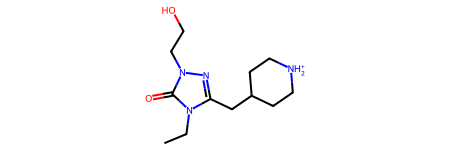

In [26]:
Chem.MolFromSmiles("CCN1C(CC2CC[NH2+]CC2)=NN(CCO)C1=O")

In [13]:

# Use the driver
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session() as session:
        for m in Chem.SDMolSupplier("./samples.sdf"):
            print("processing")
            session.execute_write(upload_mol, m, "sample_gdb9")
            print("done")
        for m in Chem.SDMolSupplier("./example.mol"):
            print("processing")
            session.execute_write(upload_mol, m, "example")
            print("done")

processing
done
processing
done
processing
done
processing
done
processing
done
processing
done


In [22]:
import pandas as pd
from tqdm.auto import tqdm

def lazy_smiles_iterator(df):
    for s in tqdm(df['smiles']):
        m:Chem.rdchem.Mol = Chem.MolFromSmiles(s)
        m.SetProp("_Name",s)
        yield m
        
def lazy_props_iterator(df):
    for i,r in df.iterrows():
        yield {
            k:v for k,v in dict(r).items() if is_valid_fieldname(k) and is_primitive(v)
        }
        
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    sourcefile="zinc_250k_10k.csv"
    zinc=pd.read_csv(sourcefile).iloc[:1000]
    with driver.session() as session:
        session.execute_write(
            upload_mols, 
            lazy_smiles_iterator(zinc), 
            sourcefile, 
            lazy_props_iterator(zinc)
        )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
for m in lazy_smiles_iterator(pd.read_csv("zinc_250k_10k.csv")):
    pass

  0%|          | 0/10000 [00:00<?, ?it/s]

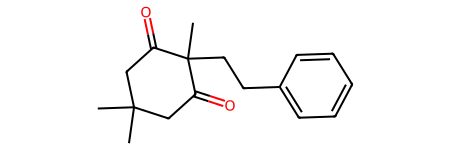

In [20]:
m

In [ ]:
tmp=Chem.MolFromSmiles("CC[C@H](C(=O)O)N[C@@H](CC1=CC=CC=C1)C(=O)[N-]")
tmp

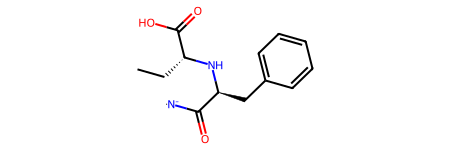

=== MOL PROPS ===
{}
=== ATOMS PROPS ===
{'_CIPRank': 0, 'Idx': 0, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 3}
{'_CIPRank': 1, 'Idx': 1, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 2}
{'_CIPRank': 8, '_ChiralityPossible': 1, '_CIPCode': 'R', 'Idx': 2, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, 'NumImplicitHs': 0}
{'_CIPRank': 10, 'Idx': 3, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 0}
{'_CIPRank': 15, 'Idx': 4, 'Symbol': 'O', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 0}
{'_CIPRank': 13, 'Idx': 5, 'Symbol': 'O', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 1}
{'_CIPRank': 12, 'Idx': 6, 'Symbol': 'N', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 1}
{'_CIPRank': 7, '_ChiralityPossible': 1, '_CIPCode': 'S', 'Idx': 7, '

In [156]:
print_mol_props(tmp)

In [189]:
try:
    mol.GetProp("_Namea")
except:
    print("e")

e


In [128]:

for atom in (tmp).GetAtoms():
    props = {k:v for k,v in atom.GetPropsAsDict().items() if is_primitive(v)}
    
    n_confs = tmp.GetNumConformers()
    props_conformer = {}
    if n_confs>1: raise Exception("what does >1 conformer even mean??!")
    elif n_confs==1:
        props_conformer = {k:v for k,v in conf.GetPropsAsDict().items() if is_primitive(v)}
        conf=mol.GetConformer()
        pos=conf.GetAtomPosition(atom.GetIdx())
        props_conformer['x']=pos.x
        props_conformer['y']=pos.y
        props_conformer['z']=pos.z
    props={**props, **props_conformer}
    print(atom.GetSymbol(), atom.GetChiralTag(), atom.GetNumImplicitHs(), atom.GetFormalCharge(), props)

C CHI_UNSPECIFIED 3 0 {'_CIPRank': 0}
C CHI_UNSPECIFIED 2 0 {'_CIPRank': 1}
C CHI_TETRAHEDRAL_CCW 0 0 {'_CIPRank': 8, '_ChiralityPossible': 1, '_CIPCode': 'R'}
C CHI_UNSPECIFIED 0 0 {'_CIPRank': 10}
O CHI_UNSPECIFIED 0 0 {'_CIPRank': 15}
O CHI_UNSPECIFIED 1 0 {'_CIPRank': 13}
N CHI_UNSPECIFIED 1 0 {'_CIPRank': 12}
C CHI_TETRAHEDRAL_CW 0 0 {'_CIPRank': 7, '_ChiralityPossible': 1, '_CIPCode': 'S'}
C CHI_UNSPECIFIED 2 0 {'_CIPRank': 2}
C CHI_UNSPECIFIED 0 0 {'_CIPRank': 6}
C CHI_UNSPECIFIED 1 0 {'_CIPRank': 5}
C CHI_UNSPECIFIED 1 0 {'_CIPRank': 4}
C CHI_UNSPECIFIED 1 0 {'_CIPRank': 3}
C CHI_UNSPECIFIED 1 0 {'_CIPRank': 4}
C CHI_UNSPECIFIED 1 0 {'_CIPRank': 5}
C CHI_UNSPECIFIED 0 0 {'_CIPRank': 9}
O CHI_UNSPECIFIED 0 0 {'_CIPRank': 14}
N CHI_UNSPECIFIED 0 -1 {'_CIPRank': 11}


In [125]:
atom.GetPropsAsDict()

{'__computedProps': <rdkit.rdBase._vectclass std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > at 0x259c2455f40>,
 '_CIPRank': 11}

In [126]:
{k:v for k,v in atom.GetPropsAsDict().items() if is_primitive(v)}

{'_CIPRank': 11}

In [36]:

for a in Chem.AddHs(Chem.MolFromSmiles("[NH4+]")).GetAtoms():
    print(a.GetSymbol(), a.GetChiralTag(), a.GetExplicitValence(),)

N CHI_UNSPECIFIED 4
H CHI_UNSPECIFIED 1
H CHI_UNSPECIFIED 1
H CHI_UNSPECIFIED 1
H CHI_UNSPECIFIED 1


In [93]:
mol.GetNumConformers()

1

In [157]:
type(tmp)

rdkit.Chem.rdchem.Mol

In [166]:
def print_mol_props(mol: rdkit.Chem.rdchem.Mol):
    
    display(mol)
    print("=== MOL PROPS ===")
    n_confs = mol.GetNumConformers()
    props = {k:v for k,v in mol.GetPropsAsDict().items() if is_primitive(v)}
    props['NumAtoms'] = mol.GetNumAtoms()
    props['NumHeavyAtoms'] = mol.GetNumHeavyAtoms()
    props['NumBonds'] = mol.GetNumBonds()
    props['NumConformers'] = n_confs
    if n_confs==1:
        conf=mol.GetConformer()
        props = {**props, **{k:v for k,v in conf.GetPropsAsDict().items() if is_primitive(v)}}
    print(props)
    print("=== ATOMS PROPS ===")
    for atom in (mol).GetAtoms():
        props = {k:v for k,v in atom.GetPropsAsDict().items() if is_primitive(v)}
        props['Idx']=atom.GetIdx()
        props['Symbol']=atom.GetSymbol()
        props['ChiralTag']=atom.GetChiralTag()
        props['NumImplicitHs']=atom.GetNumImplicitHs()
        if n_confs>1: raise Exception("what does >1 conformer even mean??!")
        elif n_confs==1:
            pos=conf.GetAtomPosition(atom.GetIdx())
            props['x']=pos.x
            props['y']=pos.y
            props['z']=pos.z
        print(props)
    print("=== BONDS PROPS ===")

    for bond in mol.GetBonds():
        props = {k:v for k,v in bond.GetPropsAsDict().items() if is_primitive(v)}
        props['Idx']=atom.GetIdx()
        props['IsAromatic']=bond.GetIsAromatic()
        props['IsConjugated']=bond.GetIsConjugated()
        props['BondType']=bond.GetBondType()
        props['Stereo']=bond.GetStereo()
        props['BeginAtomIdx']=bond.GetBeginAtomIdx()
        props['EndAtomIdx']=bond.GetEndAtomIdx()
        print(props)

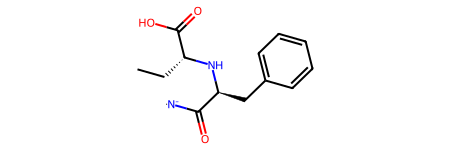

=== MOL PROPS ===
{'NumAtoms': 18, 'NumHeavyAtoms': 18, 'NumBonds': 18, 'NumConformers': 0}
=== ATOMS PROPS ===
{'_CIPRank': 0, 'Idx': 0, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 3}
{'_CIPRank': 1, 'Idx': 1, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 2}
{'_CIPRank': 8, '_ChiralityPossible': 1, '_CIPCode': 'R', 'Idx': 2, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, 'NumImplicitHs': 0}
{'_CIPRank': 10, 'Idx': 3, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 0}
{'_CIPRank': 15, 'Idx': 4, 'Symbol': 'O', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 0}
{'_CIPRank': 13, 'Idx': 5, 'Symbol': 'O', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 1}
{'_CIPRank': 12, 'Idx': 6, 'Symbol': 'N', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 1

In [167]:
print_mol_props(tmp)

In [177]:
suppl.GetItemText(0)

'470\n  -OEChem-03231300073D\n\n 18 17  0     1  0  0  0  0  0999 V2000\n    1.0306    1.6399   -0.7243 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8454    0.5515    1.0905 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2894   -1.8469   -0.1464 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.1271    0.2139    0.3789 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9234   -0.8189    0.0722 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4864   -0.6787   -0.5160 C   0  0  1  0  0  0  0  0  0  0  0  0\n   -1.8029    0.4035   -0.2036 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2016    0.5357    0.0487 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4018   -1.7164   -0.3424 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8579   -0.9676    1.1593 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4512   -0.6051   -1.6086 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.3711    1.3052    0.2400 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.8971    0.5673   -1.2825 H   0  0  0  0  0  0  0  0  0  0  0  0\n    

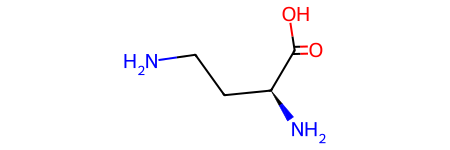

=== MOL PROPS ===
{'PUBCHEM_COMPOUND_CID': '470\n$$$$', 'NumAtoms': 8, 'NumHeavyAtoms': 8, 'NumBonds': 7, 'NumConformers': 1}
=== ATOMS PROPS ===
{'_CIPRank': 6, 'Idx': 0, 'Symbol': 'O', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 1, 'x': 1.0306, 'y': 1.6399, 'z': -0.7243}
{'_CIPRank': 7, 'Idx': 1, 'Symbol': 'O', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 0, 'x': 1.8454, 'y': 0.5515, 'z': 1.0905}
{'_CIPRank': 5, 'Idx': 2, 'Symbol': 'N', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 2, 'x': 1.2894, 'y': -1.8469, 'z': -0.1464}
{'_CIPRank': 4, 'Idx': 3, 'Symbol': 'N', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 2, 'x': -3.1271, 'y': 0.2139, 'z': 0.3789}
{'_CIPRank': 0, 'Idx': 4, 'Symbol': 'C', 'ChiralTag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'NumImplicitHs': 0, 'x': -0.9234, 'y': -0.8189, 'z': 0.0722}
{'molParity': 1, '_CIPRank': 2, '_ChiralityPossible':

In [178]:
suppl=(Chem.SDMolSupplier("example.mol"))
for mol in suppl:
    print_mol_props(mol)

'470'

In [50]:
atom=mol.GetAtomWithIdx(2)
(atom.GetSymbol(), atom.GetChiralTag(), atom.GetExplicitValence(),)

('N', rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 1)

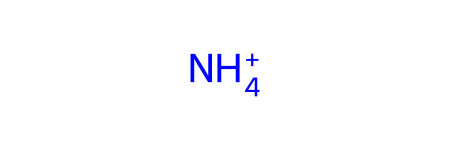

In [18]:
Chem.MolFromSmiles("[NH4+]")

In [36]:

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session() as session:
        display(session.run("MATCH (n:Molecule)-[:PART_OF]->(s:Source) return n").data())

[{'n': {'software': '-OEChem-03231823243D',
   'id': 'gdb_1',
   'version': 'V2000'}},
 {'n': {'software': '-OEChem-03231823233D',
   'id': 'gdb_2',
   'version': 'V2000'}},
 {'n': {'software': '-OEChem-03231823243D',
   'id': 'gdb_3',
   'version': 'V2000'}},
 {'n': {'software': '-OEChem-03231823253D',
   'id': 'gdb_4',
   'version': 'V2000'}},
 {'n': {'software': 'ChemDraw2024',
   'LogP': '0.83',
   'id': 'CO2',
   'version': 'V2000'}}]

In [95]:

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session() as session:
        result=(session.run("MATCH (a:Atom)-[b:BOND]->(a2:Atom)-[:PART_OF]->(m:Molecule{id:'CO2'}) return a,b,a2"))
        for row in result:
            out=(row['b'])

In [96]:
dict(out)

{'bond_stereo': 'Use_coordinates', 'id': 'bond1', 'bond_type': 'Double'}

In [52]:
tmp[0]['b']

({'symbol': 'C',
  'charge': 'outside_limits',
  'stereo_parity': 'not_stereo',
  'mass_diff': '0',
  'x': -0.72,
  'y': 0.0,
  'valence': 'no marking',
  'z': 0.0,
  'id': 'atom1'},
 'BOND',
 {'symbol': 'O',
  'charge': 'outside_limits',
  'stereo_parity': 'not_stereo',
  'mass_diff': '0',
  'x': 0.72,
  'y': 0.0,
  'valence': 'no marking',
  'z': 0.0,
  'id': 'atom2'})

In [74]:
import threading
from time import sleep, time
sem = threading.Semaphore(2)
def fun1():
    n=3
    while n>0:
        sleep(0.00000001)
        with sem:
            n-=1
            print(1)
            sleep(1)

def fun2():
    n=3
    while n>0:
        sleep(0.00000001)
        with sem:
            n-=1
            print(2)
            sleep(1)
start=time()
t = threading.Thread(target = fun1)
t.start()
t2 = threading.Thread(target = fun2)
t2.start()
t.join()
t2.join()
print("took",time()-start,"seconds")

1
2
2
1
21

took 3.0773708820343018 seconds
